# 1. Data Acquisition

In [1]:
# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import recall_score,precision_score,f1_score,confusion_matrix,roc_curve,roc_auc_score,accuracy_score
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

In [2]:
# Reading CSV file
df = pd.read_csv("Fraud.csv")

In [3]:
# Checking how big the data is
df.shape

(6362620, 11)

In [4]:
# How data look like
df.sample(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
4684978,331,CASH_IN,235060.40,C492004920,3392835.92,3627896.32,C2001396534,412820.45,177760.05,0,0
5787308,401,PAYMENT,15792.02,C1322913614,0.00,0.00,M1538938926,0.00,0.00,0,0
5840889,402,PAYMENT,9548.15,C365226074,145434.76,135886.60,M460221560,0.00,0.00,0,0
2034217,180,CASH_OUT,252339.00,C16800888,175759.02,0.00,C1619767054,1622329.03,1874668.04,0,0
2938237,230,CASH_OUT,65800.02,C88715905,0.00,0.00,C238825047,251784.18,317584.19,0,0


In [5]:
# Checking the data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [6]:
# Check for null values
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

*  No null values found




In [7]:
# Check for duplicated rows
df.duplicated().sum()

0

*  No duplicated rows detected

# 2. Exploratory Data Analysis

#### 1. Exploring categorical feature

In [8]:
categorical_feature = [feature for feature in df.columns if (df[feature].dtypes=='object')]
categorical_feature

['type', 'nameOrig', 'nameDest']

*  Here **nameOrig**, **nameDest** doesn't carry any relationship with the label so it will be removed during feature engg step
*  We will analyse only for column **type** here


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='type', ylabel='count'>

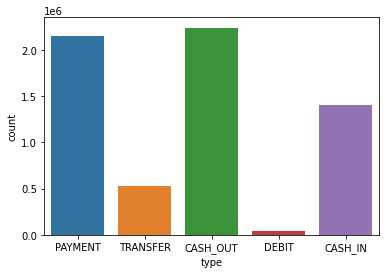

In [9]:
sns.countplot(df['type'])

*  **CASH_OUT** is larger in number as compared with other 

#### 2. Exploring Numerical features


In [10]:
numerical_feature = [feature for feature in df.columns if (df[feature].dtypes=='float64')]
numerical_feature

['amount',
 'oldbalanceOrg',
 'newbalanceOrig',
 'oldbalanceDest',
 'newbalanceDest']

<AxesSubplot:>

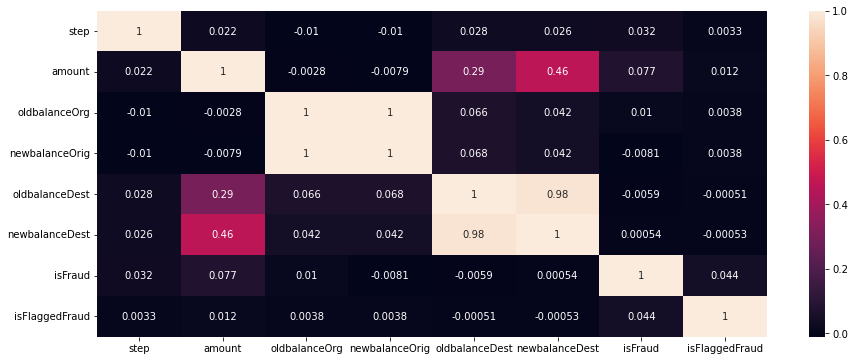

In [11]:
corr_mat = df.corr()
plt.figure(figsize=(15,6))
sns.heatmap(corr_mat,annot = True)

*  Here, column having correlation quite close to zero with respect to Label, will be removed during feature engg step
*  multicollinearity exists between **oldbalanceOrg** and **newbalanceOrig** & **oldbalanceDest** and **newbalanceDest**

# 3. Feature Engineering

#### 1. Outlier Detection and Removal

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='amount', ylabel='Density'>

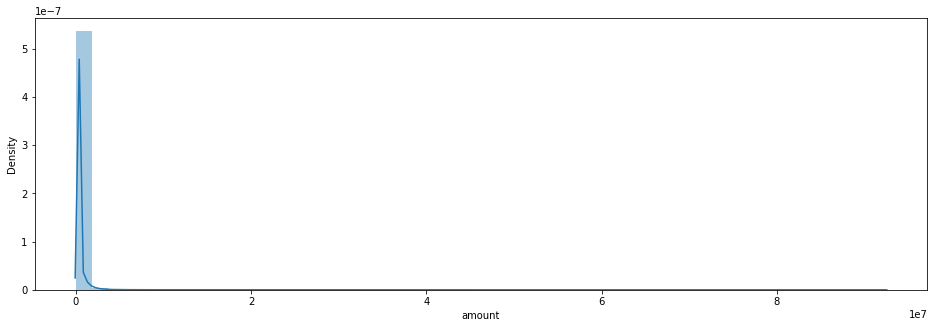

In [12]:
# Checking with PDF distribution
plt.figure(figsize=(16,5))
sns.distplot(df['amount'])

*  Highly skewed distribution found so going for IQR outlier detection & removal process

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='amount'>

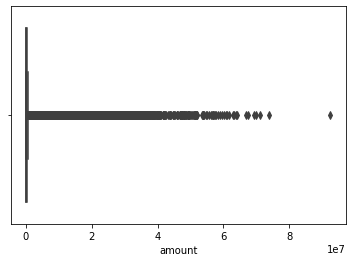

In [13]:
# Checking with Boxplot 
sns.boxplot('amount',data=df)

*  Large no of outliers detected so going for outlier removal using IQR method

In [14]:
# Finding the IQR
percentile25 = df['amount'].quantile(0.25)
percentile75 = df['amount'].quantile(0.75)
IQR = percentile75-percentile25
upper_limit = percentile75 + 1.5*IQR
lower_limit = percentile25 - 1.5*IQR
print("upper limit", upper_limit)
print("lower limit", lower_limit)

upper limit 501719.33875
lower limit -279608.29125


In [15]:
df[df['amount'] > upper_limit]


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
85,1,TRANSFER,1505626.01,C926859124,0.00,0.0,C665576141,29031.00,5515763.34,0,0
86,1,TRANSFER,554026.99,C1603696865,0.00,0.0,C766572210,579285.56,0.00,0,0
88,1,TRANSFER,761507.39,C412788346,0.00,0.0,C1590550415,1280036.23,19169204.93,0,0
89,1,TRANSFER,1429051.47,C1520267010,0.00,0.0,C1590550415,2041543.62,19169204.93,0,0
93,1,TRANSFER,583848.46,C1839168128,0.00,0.0,C1286084959,667778.00,2107778.11,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362613,743,CASH_OUT,1258818.82,C1436118706,1258818.82,0.0,C1240760502,503464.50,1762283.33,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0


*  These values are Outliers. Since we have significant amount of data so we will trim the outliers detected

In [16]:
new_df = df[df['amount'] < upper_limit]

In [17]:
new_df.shape

(6024542, 11)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='amount'>

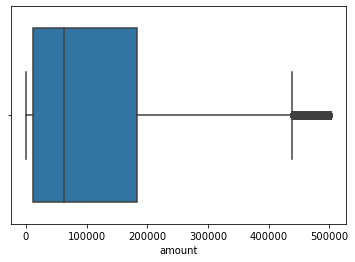

In [18]:
# Again Checking with Boxplot
sns.boxplot(new_df['amount'])

*  Now the outliers are being removed from our dataset

#### 2. Checking for multicollinearity

In [19]:
# Function for calculating Variance Inflation Factor
def calculate_vif(dataset):
    vif = pd.DataFrame()
    vif['features'] = dataset.columns
    vif['VIF_Value'] = [variance_inflation_factor(dataset.values,i) for i in range(dataset.shape[1])]
    return (vif)

In [20]:
features=new_df[['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud','isFraud']]
features
calculate_vif(features)

,features,VIF_Value
0,step,1.562840
1,amount,2.244722
2,oldbalanceOrg,1606.453870
3,newbalanceOrig,1625.437648
4,oldbalanceDest,231.599150
5,newbalanceDest,234.878078
6,isFlaggedFraud,1.000461
7,isFraud,1.006938


*  Collinearity detected among 4 features so checking with heatmap for feature removal

<AxesSubplot:>

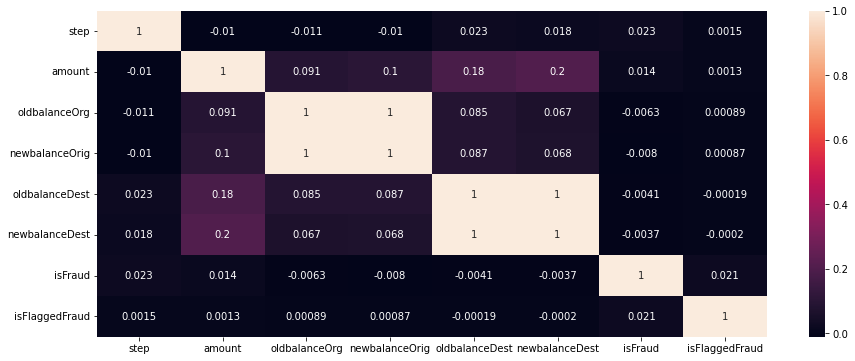

In [21]:
corr_mat = new_df.corr()
plt.figure(figsize=(15,6))
sns.heatmap(corr_mat,annot = True)

*  Here we will drop **newbalanceOrig** & **oldbalanceDest** since it has lesser correlation with the Label 

In [22]:
features.drop(columns=['newbalanceOrig','oldbalanceDest'],inplace=True)
features
calculate_vif(features)

C:\Users\Jaunel\AppData\Local\Temp\ipykernel_21616\3041615373.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.drop(columns=['newbalanceOrig','oldbalanceDest'],inplace=True)


,features,VIF_Value
0,step,1.548638
1,amount,1.641109
2,oldbalanceOrg,1.087425
3,newbalanceDest,1.163829
4,isFlaggedFraud,1.000460
5,isFraud,1.001899


*  Now, no Collinearity found among the features. So We will proceed with above features only

In [23]:
new_df.head(2)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0


In [24]:
new_df.drop(columns=['newbalanceOrig','oldbalanceDest','nameOrig','nameDest'],inplace=True)
new_df

C:\Users\Jaunel\AppData\Local\Temp\ipykernel_21616\383062270.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(columns=['newbalanceOrig','oldbalanceDest','nameOrig','nameDest'],inplace=True)


,step,type,amount,oldbalanceOrg,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,170136.00,0.00,0,0
1,1,PAYMENT,1864.28,21249.00,0.00,0,0
2,1,TRANSFER,181.00,181.00,0.00,1,0
3,1,CASH_OUT,181.00,181.00,0.00,1,0
4,1,PAYMENT,11668.14,41554.00,0.00,0,0
...,...,...,...,...,...,...,...
6362609,742,CASH_OUT,258355.42,258355.42,283532.09,1,0
6362610,742,TRANSFER,63416.99,63416.99,0.00,1,0
6362611,742,CASH_OUT,63416.99,63416.99,339850.17,1,0
6362614,743,TRANSFER,339682.13,339682.13,0.00,1,0


#### 3.One Hot Encoding with Categorical feature

In [25]:
new_df = pd.get_dummies(new_df,columns=['type'],drop_first=True)

In [26]:
new_df

,step,amount,oldbalanceOrg,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.00,0.00,0,0,0,0,1,0
1,1,1864.28,21249.00,0.00,0,0,0,0,1,0
2,1,181.00,181.00,0.00,1,0,0,0,0,1
3,1,181.00,181.00,0.00,1,0,1,0,0,0
4,1,11668.14,41554.00,0.00,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
6362609,742,258355.42,258355.42,283532.09,1,0,1,0,0,0
6362610,742,63416.99,63416.99,0.00,1,0,0,0,0,1
6362611,742,63416.99,63416.99,339850.17,1,0,1,0,0,0
6362614,743,339682.13,339682.13,0.00,1,0,0,0,0,1


# 4. Data Splitting

#### 1.Splitting the dataset into feature and Label

In [27]:
x=new_df.drop(['isFraud'],axis=1)
y=new_df['isFraud']

#### 2. Standardization

In [28]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
x=sc.fit_transform(x)

In [29]:
y.value_counts()

0    6020183
1       4359
Name: isFraud, dtype: int64

*  Highly imbalanced dataset found

#### 3.Splitting the dataset into train & test data with stratified sampling

In [30]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=1,stratify=y)

In [31]:
y_train.value_counts(normalize=True)*100

0    99.92765
1     0.07235
Name: isFraud, dtype: float64

#### 4.OverSampling the train data 

In [32]:
os = RandomOverSampler()
x_train_res, y_train_res = os.fit_resample(x_train,y_train)

In [33]:

print('Original dataset shape {}'.format(Counter(y_train)))
print('Resampled dataset shape {}'.format(Counter(y_train_res)))


Original dataset shape Counter({0: 4816146, 1: 3487})
Resampled dataset shape Counter({0: 4816146, 1: 4816146})


*  Now our train data contain fair share of both these categories

In [34]:
x_train.shape, x_train_res.shape

((4819633, 9), (9632292, 9))

#  5. Model Training & Evaluation

#### 1. Using Logistic Regression Algorithm


In [35]:
from sklearn.linear_model import LogisticRegression
classifier1=LogisticRegression(random_state=0)
classifier1.fit(x_train_res,y_train_res)
y_pred1=classifier1.predict(x_test)

#Performance Metrics
print('For Logistic Regression Model')
print("-"*50)
lr = pd.DataFrame(confusion_matrix(y_test,y_pred1),columns=list(range(0,2)))
print(lr)
print("-"*50)
print("Accuracy - ", accuracy_score(y_test,y_pred1))
print("Precision - ", precision_score(y_test,y_pred1))
print("Recall - ", recall_score(y_test,y_pred1))
print("F1 score - ", f1_score(y_test,y_pred1))


For Logistic Regression Model
--------------------------------------------------
         0       1
0  1080948  123089
1       33     839
--------------------------------------------------
Accuracy -  0.8978163496164441
Precision -  0.00677006003485895
Recall -  0.9621559633027523
F1 score -  0.013445512820512822


#### 2. Using Random Forest Algorithm

In [36]:
from sklearn.ensemble import RandomForestClassifier
classifier2=RandomForestClassifier(n_estimators=5,criterion='entropy',random_state=0)
classifier2.fit(x_train_res,y_train_res)
y_pred2=classifier2.predict(x_test)

#Performance Metrics
print('For Random Forest Model')
print("-"*50)
lr = pd.DataFrame(confusion_matrix(y_test,y_pred2),columns=list(range(0,2)))
print(lr)
print("-"*50)
print("Accuracy - ", accuracy_score(y_test,y_pred2))
print("Precision - ", precision_score(y_test,y_pred2))
print("Recall - ", recall_score(y_test,y_pred2))
print("F1 score - ", f1_score(y_test,y_pred2))


For Random Forest Model
--------------------------------------------------
         0    1
0  1203950   87
1      332  540
--------------------------------------------------
Accuracy -  0.9996522558965034
Precision -  0.861244019138756
Recall -  0.6192660550458715
F1 score -  0.7204803202134756


#### 3. Using Gradient Boosting Algorithm

In [37]:
from xgboost import XGBClassifier
classifier3=XGBClassifier(n_estimators=5,objective='binary:logistic',learning_rate=0.1)
classifier3.fit(x_train,y_train)
y_pred3=classifier3.predict(x_test)

#Performance Metrics
print('For Gradient Boost Model')
print("-"*50)
lr = pd.DataFrame(confusion_matrix(y_test,y_pred3),columns=list(range(0,2)))
print(lr)
print("-"*50)
print("Accuracy - ", accuracy_score(y_test,y_pred3))
print("Precision - ", precision_score(y_test,y_pred3))
print("Recall - ", recall_score(y_test,y_pred3))
print("F1 score - ", f1_score(y_test,y_pred3))


For Gradient Boost Model
--------------------------------------------------
         0    1
0  1204016   21
1      448  424
--------------------------------------------------
Accuracy -  0.9996107589867782
Precision -  0.952808988764045
Recall -  0.48623853211009177
F1 score -  0.6438876233864844


#### 4. Evaluation using ROC AUC Curve

In [38]:
#calculating predicted probabilities for every model
log_reg = classifier1.predict_proba(x_test)
rf_cls = classifier2.predict_proba(x_test)
gb_cls = classifier3.predict_proba(x_test)

#probabilities for positive outcome 
log_reg = log_reg[:,1]
rf_cls = rf_cls[:,1]
gb_cls = gb_cls[:,1]

#calculating roc_auc score for each model
log_reg_auc = roc_auc_score(y_test,log_reg)
rf_auc = roc_auc_score(y_test,rf_cls)
gb_auc = roc_auc_score(y_test,gb_cls)
print("ROC-AUC score for Logistic Regression Model is",log_reg_auc)
print("ROC-AUC score for Random Forest Model is",rf_auc)
print("ROC-AUC score for Gradient Boost Model is",gb_auc)

ROC-AUC score for Logistic Regression Model is 0.96641725547265
ROC-AUC score for Random Forest Model is 0.8936838116880084
ROC-AUC score for Gradient Boost Model is 0.8577880505599994


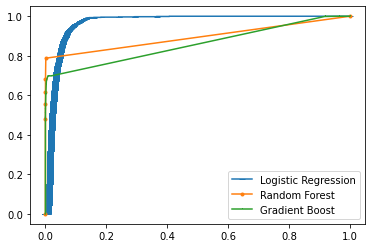

In [39]:
#calculating ROC Curve
log_reg_fpr,log_reg_tpr, _ = roc_curve(y_test,log_reg)
rf_fpr,rf_tpr, _=  roc_curve(y_test,rf_cls)
gb_fpr,gb_tpr, _ = roc_curve(y_test,gb_cls)

#Plotting ROC Curve
plt.plot(log_reg_fpr,log_reg_tpr,marker='_',label='Logistic Regression')
plt.plot(rf_fpr,rf_tpr,marker='.',label='Random Forest')
plt.plot(gb_fpr,gb_tpr,marker=',',label='Gradient Boost')
plt.legend()
plt.show()

# 6.Conclusion

Based upon the provided evaluation metrics, the Random Forest and Gradient Boost models have higher accuracy scores than the Logistic Regression model, which suggests they may perform better in predicting the target variable.
Given that the dataset is highly imbalanced we will consider precision and recall score as our deciding factor.

In fraud detection, precision is generally considered a more reliable metric than recall. This is because in fraud detection, the cost associated with false positive is often much higher than the cost of a false negative. Therefore, we will try to minimize false positives cases and ensure that legitimate transactions are not wrongly classified as fraudulent.

Even though Gradient Boost is having slightly lesser ROC-AUC score but since its having higher precision score than Random Forest, So I have selected **Gradient Boost** as the best model for this case

# 7. Optimization

Employing dropout techniques in deep learning algorithms such as artificial neural networks (ANN) can lead to enhanced Model performance.

####  Key factors that predict fraudulent customer



Checking source of request or transaction history of vendors could be few factors in predicting fradulent customers

#### Prevention adopted while updating company Infrastructure

Browsing securely, using verified apps and securing internet connection could be employed while updating infrastructure